In [1]:
import pathlib
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

c:\users\lmh\.conda\envs\tf20\lib\importlib\_bootstrap.py:205: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)


In [2]:
dataset_path=keras.utils.get_file('cuto0mpg.data','http://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data')
dataset_path

32768/30286 [================================] - 0s 7us/step


'C:\\Users\\lmh\\.keras\\datasets\\cuto0mpg.data'

In [3]:
column_name=['MPG','Cylinders','Displacement','Horsepower','Weight',
                'Acceleration', 'Model Year', 'Origin']
raw_dataset=pd.read_csv(dataset_path,names=column_name,
                       na_values='?',comment='\t',
                       sep=' ',skipinitialspace=True)
dataset=raw_dataset.copy()
dataset.tail()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin
393,27.0,4,140.0,86.0,2790.0,15.6,82,1
394,44.0,4,97.0,52.0,2130.0,24.6,82,2
395,32.0,4,135.0,84.0,2295.0,11.6,82,1
396,28.0,4,120.0,79.0,2625.0,18.6,82,1
397,31.0,4,119.0,82.0,2720.0,19.4,82,1


In [4]:
dataset.isna().sum()

MPG             0
Cylinders       0
Displacement    0
Horsepower      6
Weight          0
Acceleration    0
Model Year      0
Origin          0
dtype: int64

In [5]:
dataset=dataset.dropna()

In [6]:
origin=dataset.pop('Origin')

In [7]:
dataset['USA']=(origin==1)*1.0
dataset['Europe']=(origin==2)*1.0
dataset['Japan']=(origin==3)*1.0
dataset.tail()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,USA,Europe,Japan
393,27.0,4,140.0,86.0,2790.0,15.6,82,1.0,0.0,0.0
394,44.0,4,97.0,52.0,2130.0,24.6,82,0.0,1.0,0.0
395,32.0,4,135.0,84.0,2295.0,11.6,82,1.0,0.0,0.0
396,28.0,4,120.0,79.0,2625.0,18.6,82,1.0,0.0,0.0
397,31.0,4,119.0,82.0,2720.0,19.4,82,1.0,0.0,0.0


In [8]:
train_data=dataset.sample(frac=0.8,random_state=0)
test_data=dataset.drop(train_data.index)

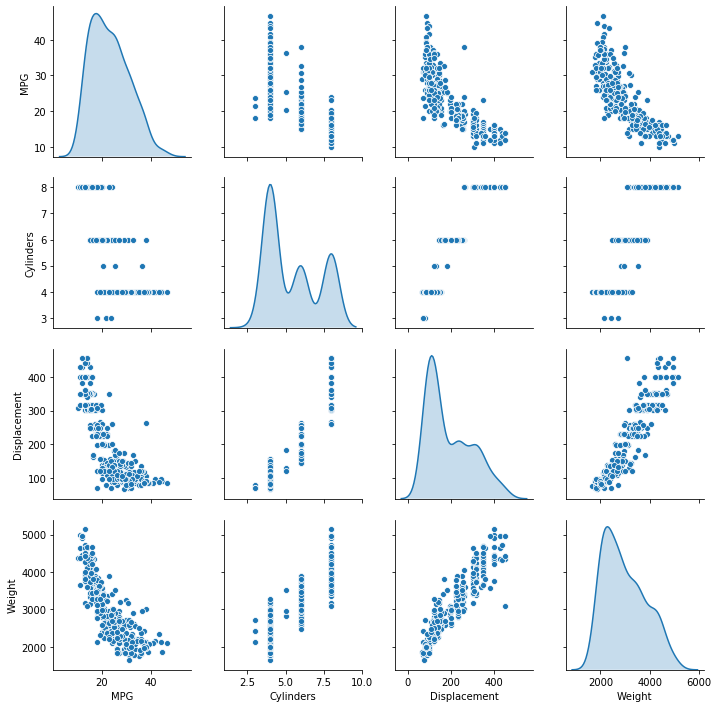

In [10]:
sns.pairplot(train_data[['MPG','Cylinders','Displacement','Weight']],diag_kind='kde')

In [13]:
train_stats=train_data.describe()
train_stats.pop('MPG')
train_stats=train_stats.transpose()
train_stats

,count,mean,std,min,25%,50%,75%,max
Cylinders,314.0,5.477707,1.699788,3.0,4.00,4.0,8.00,8.0
Displacement,314.0,195.318471,104.331589,68.0,105.50,151.0,265.75,455.0
Horsepower,314.0,104.869427,38.096214,46.0,76.25,94.5,128.00,225.0
Weight,314.0,2990.251592,843.898596,1649.0,2256.50,2822.5,3608.00,5140.0
Acceleration,314.0,15.559236,2.789230,8.0,13.80,15.5,17.20,24.8
Model Year,314.0,75.898089,3.675642,70.0,73.00,76.0,79.00,82.0
USA,314.0,0.624204,0.485101,0.0,0.00,1.0,1.00,1.0
Europe,314.0,0.178344,0.383413,0.0,0.00,0.0,0.00,1.0
Japan,314.0,0.197452,0.398712,0.0,0.00,0.0,0.00,1.0


In [14]:
train_labels=train_data.pop('MPG')
test_labels=test_data.pop('MPG')

In [19]:
def norm(x):
    return (x-train_stats['mean'])/train_stats['std']
norm_train_data=norm(train_data)
norm_test_data=norm(test_data)

In [49]:
from sklearn.preprocessing import StandardScaler
scaler=StandardScaler()
train_data_scaled=scaler.fit_transform(train_data)
test_data_scaled=scaler.transform(test_data)

In [50]:
train_data_scaled=pd.DataFrame(train_data_scaled)
test_data_scaled=pd.DataFrame(test_data_scaled)

In [25]:
test_data_scaled[:3]

array([[ 1.48625572,  1.86896678,  2.23818711,  1.0204078 , -2.53493044,
        -1.60720297,  0.77591289, -0.46589083, -0.49601587],
       [ 1.48625572,  1.58096307,  2.89546775,  1.92836176, -0.55991245,
        -1.60720297,  0.77591289, -0.46589083, -0.49601587],
       [ 1.48625572,  1.04335613,  2.31706079,  2.06722531,  1.05601136,
        -1.60720297,  0.77591289, -0.46589083, -0.49601587]])

In [24]:
norm_test_data[:3]

,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,USA,Europe,Japan
9,1.483887,1.865988,2.234620,1.018782,-2.530891,-1.604642,0.774676,-0.465148,-0.495225
25,1.483887,1.578444,2.890853,1.925289,-0.559020,-1.604642,0.774676,-0.465148,-0.495225
28,1.483887,1.041693,2.313368,2.063931,1.054328,-1.604642,0.774676,-0.465148,-0.495225


In [26]:
def build_model():
    model=keras.Sequential([
        layers.Dense(64,activation='relu',input_shape=[len(train_data.keys())]),
        layers.Dense(64,activation='relu'),
        layers.Dense(1)
    ])
    optimizer=tf.keras.optimizers.RMSprop(0.001)
    model.compile(loss='mse',
                 optimizer=optimizer,
                 metrics=['mae','mse'])
    return model

In [27]:
model=build_model()

In [28]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                640       
_________________________________________________________________
dense_1 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 65        
Total params: 4,865
Trainable params: 4,865
Non-trainable params: 0
_________________________________________________________________


In [29]:
example_batch=norm_train_data[:10]
example_result=model.predict(example_batch)
example_result

array([[-0.32504776],
       [-0.17610645],
       [-0.02306402],
       [-0.11141744],
       [ 0.19276756],
       [-0.03825906],
       [ 0.18060188],
       [ 0.41536808],
       [-0.17823607],
       [-0.5162049 ]], dtype=float32)

In [51]:
class PrintDot(keras.callbacks.Callback):
    def on_epoch_end(self,epoch,logs):
        if epoch%100==0:print('')
        print('.',end='')
epoch=1000
history=model.fit(train_data_scaled,train_labels,
                 epochs=epoch,validation_split=0.2,verbose=0,
                 callbacks=[PrintDot()])


....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
..........................................................................................

In [33]:
hist=pd.DataFrame(history.history)

In [35]:
hist['epoch']=history.epoch
hist.head()

,loss,mae,mse,val_loss,val_mae,val_mse,epoch
0,2.308188,0.989082,2.308189,9.424827,2.423879,9.424827,0
1,2.439267,1.049283,2.439267,9.933565,2.441082,9.933565,1
2,2.257485,0.962605,2.257485,9.325848,2.403511,9.325849,2
3,2.357457,0.991715,2.357457,9.784968,2.442079,9.784968,3
4,2.388490,1.011973,2.388490,8.778137,2.344280,8.778137,4


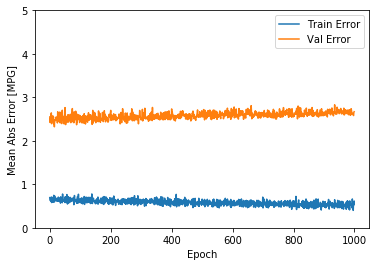

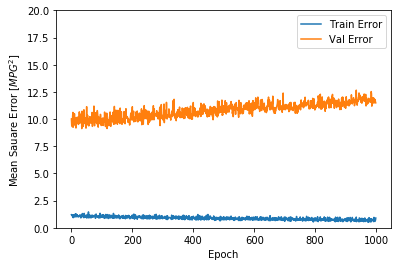

In [53]:
def plot_history(history):
    hist=pd.DataFrame(history.history)
    hist['epoch']=history.epoch
    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Mean Abs Error [MPG]')
    plt.plot(hist['epoch'],hist['mae'],label='Train Error')
    plt.plot(hist['epoch'],hist['val_mae'],label='Val Error')    
    plt.ylim([0,5])
    #plt.xlim([0,600])
    plt.legend()

    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Mean Sauare Error [$MPG^2$]')
    plt.plot(hist['epoch'],hist['mse'],label='Train Error')
    plt.plot(hist['epoch'],hist['val_mse'],label='Val Error')    
    plt.ylim([0,20])
    plt.legend()
    plt.show()
plot_history(history)
    


......................................................

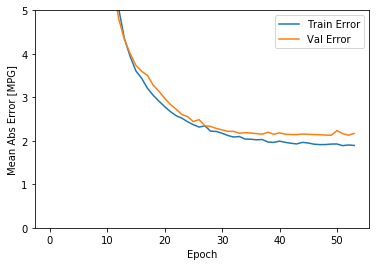

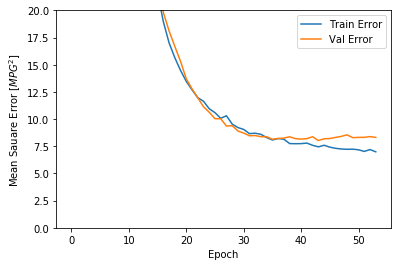

In [54]:
model=build_model()
early_stop=keras.callbacks.EarlyStopping(monitor='val_loss',patience=10)
history=model.fit(norm_train_data,train_labels,epochs=epoch,
                 validation_split=0.2,verbose=0,callbacks=[early_stop,PrintDot()])
plot_history(history)

In [55]:
loss,mae,mse=model.evaluate(norm_test_data,test_labels,verbose=0)

In [56]:
print(loss,mae,mse)

6.334856045551789 1.9157721 6.334856


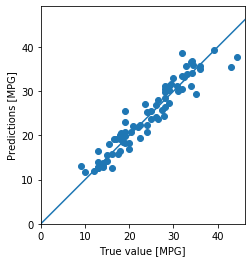

In [62]:
test_predictions=model.predict(norm_test_data).flatten()
plt.scatter(test_labels,test_predictions)
plt.xlabel('True value [MPG]')
plt.ylabel('Predictions [MPG]')
plt.axis('equal')
plt.axis('square')
plt.xlim([0,plt.xlim()[1]])
plt.ylim(0,plt.ylim()[1])
_=plt.plot([-100,100],[-100,100])

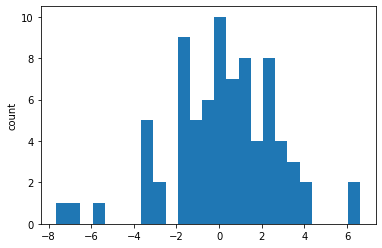

In [66]:
error=test_predictions-test_labels
plt.hist(error,bins=25)
_=plt.ylabel('count')

In [67]:
type(train_data)

pandas.core.frame.DataFrame